In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import re
from math import sqrt
import string
import json
import os

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import yfinance as yf
import snscrape.modules.twitter as sntwitter

from datetime import datetime
from datetime import date, timedelta

In [2]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def fetch_stock_details(stock_name, start_date, end_date):
    
    stock_company = yf.Ticker(stock_name)
    stock_company.info.get("longName")
    
    stock_data = yf.download(stock_name, start = start_date, end = end_date)
    print("\n Fetched stock data.")
    
    plt.title('Time series chart of Closing stocks for ' + stock_company.info.get("longName"))
    plt.plot(stock_data["Close"])
    plt.xticks(rotation = 45)
    plt.show()
    
    stock_data.to_csv(stock_name + '.csv')

In [4]:
class cleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation)

    def clean_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])

    def clean_text(self, text):
        cleaned_tweet = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_tweet =  cleaned_tweet.lower()
        cleaned_tweet =  self.clean_chars(cleaned_tweet)
        
        if re.match(r'RT @[_A-Za-z0-9]+:',cleaned_tweet):
            cleaned_tweet = cleaned_tweet[cleaned_tweet.index(':')+2:]
            
        cleaned_tweet = self.remove_hyperlinks(cleaned_tweet)
        cleaned_tweet = cleaned_tweet.replace('#','').replace('@','') 
        
        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_tweet)] 
        tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1] 
        
        cleaned_tweet = ' '.join(tokens)
        return cleaned_tweet
    
    def clean_each_tweet(self, tweet, is_bytes = False):  
        if is_bytes:
             return self.clean_text(ast.literal_eval(tweet).decode("UTF-8"))
        return self.clean_text(tweet)

In [5]:
def get_date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)        

def fetch_tweets(stock_name, start_date, end_date, num_tweets):
    
    csv_file = open('tweets_' + stock_name + '.csv', 'a', encoding="utf-8")
    csvWriter = csv.writer(csv_file, lineterminator= '\n')
    cleanObj = cleaner()
    
    stock_name = "Bitcoin"
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    
    print("Collecting tweets ...")
    tweets_list = []
    for single_date in get_date_range(start_date, end_date):
        
        startdate = single_date.strftime("%Y-%m-%d")
        enddate = datetime.strptime(startdate, '%Y-%m-%d').date() + timedelta(days=1)
        enddate = enddate.strftime("%Y-%m-%d")
        
        query = stock_name + " since:" + startdate + " until:" + enddate + " lang:en min_faves:100"

        for count, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if count > num_tweets:
                break
            
            rawContent = cleanObj.clean_text(tweet.rawContent)
            tweets_list.append([tweet.date.date(), rawContent])
    
    stock_name = "BTC-USD"
    tweets_df = pd.DataFrame(tweets_list, columns=['Date', 'Text'])
    tweets_df.to_csv('tweets_' + stock_name + '.csv')
    return tweets_df

In [6]:
def process_stock_tweets(stock_name):
    
    
    df = pd.read_csv('tweets_' + stock_name  + '.csv', encoding='utf-8', names=['Date', 'Text'], header=None)
    df = df.iloc[1:]

    data = df
    
    data['Prices']=""
    readStockData = pd.read_csv(stock_name + '.csv')
    readStockData.columns = [c.replace(' ', '_') for c in readStockData.columns]
    
    for i in range (0, len(data)):
        for j in range (0, len(readStockData)):
            get_tweet_date = data.Date.iloc[i]
            get_stock_date = readStockData.Date.iloc[j]
            
            if(str(get_stock_date)==str(get_tweet_date)):
                data.at[i, 'Prices'] = int(readStockData.Adj_Close[j])
                break


    data['Prices'].replace('', np.nan, inplace=True)
    data.dropna(subset=['Prices'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['Prices'] = data['Prices'].apply(np.int64)
    
    data.to_csv('processed_data_' + stock_name  + '.csv')
    return data

[*********************100%***********************]  1 of 1 completed

 Fetched stock data.


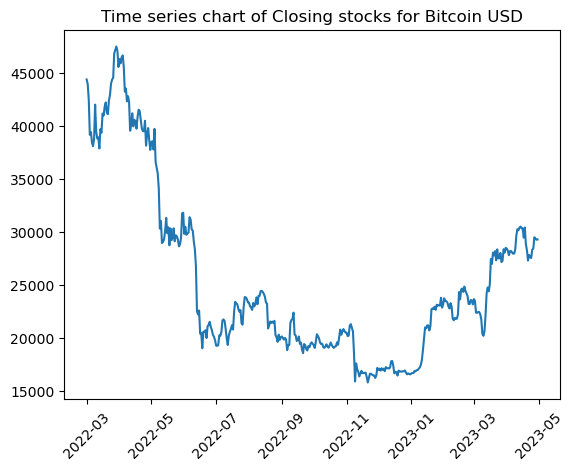

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9539b6dae06f4de'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95369a3ae15302f'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-953f8c90f29d54e'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95303325dfc88a1'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9531f4fda246870'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-953aec6f0278702'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-953f4ff3864c82e'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9535ca43a8774e2'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-953a05286e532ec'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-953c420ce60d9fa'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-953bf5bbf39fda5'
Skipping unrecognised entry ID: 'promoted-tweet-16544055714564997

Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-9547de3f9ba3356'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-954e8436d31f498'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-954fea7ad7f09c5'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9546db78a2571d3'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95419d840f74215'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95474d157e55967'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-954451613f059de'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95435d52d2ec8c5'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954749930efba60'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-954266870e0843d'
Skipping unrecognised entry ID: 'promoted-tweet-1650800315283779584-954e5335cb725dd'
Skipping unrecognised entry ID: 'promoted-tweet-16559525775135211

Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9547284b1611f70'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954ac514f208b12'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731800117250-9545bd8ccfbcdf0'
Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-95429e6d8fb7663'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9545b5a41b53177'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-954b6a372eebf06'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-954a0eea8779544'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95499a7eba063f8'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9546b8cb97c01eb'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-95464e6c857e35c'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-95489c41c3a666b'
Skipping unrecognised entry ID: 'promoted-tweet-16559525775135211

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95448345ef67e56'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9541d4e8a44ca46'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-95487c0478e788c'
Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-954e88220f92d97'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-954eea8d3bdf012'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-954346dd53bb223'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-954c5ee93aead62'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-954ef99cb430324'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-954a9f9021f1539'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954664416b6e470'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954f762d2a01791'
Skipping unrecognised entry ID: 'promoted-tweet-16559525775135211

Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-9541e4df7076ff1'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954b8f22b244bcd'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9549d726caf7d4b'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-954fe2cfc2c50cb'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9541c5897647040'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-954d141c2680fc0'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-954265ed3df68fc'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-954bfee836cde9b'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954819fbb9bc68d'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-95405bb6546c52b'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-9547b1267792136'
Skipping unrecognised entry ID: 'promoted-tweet-16560135230452121

Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-954cdbd4baffbfe'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-954c6d61155eca1'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9544826f21f6e4e'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9540ba9dd92bc66'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9545c92046f61a4'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-954f92668734834'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954f1984bf345ca'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-954680fc116d32e'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-95438405ca5bcb5'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95436f50715ec88'
Skipping unrecognised entry ID: 'promoted-tweet-1650800315283779584-95467dc135e21a3'
Skipping unrecognised entry ID: 'promoted-tweet-16559525775135211

Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9544a6bd50578bc'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954a2d9f1cb743e'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-954913569326217'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954729bffe987f7'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-954444b4f479b3f'
Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-9549e7e10b8e3ce'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-954b78b45411661'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-954dd76b613c4e8'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-954e8d9bab2e9b4'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-95456254b370d0f'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955b12cb614820f'
Skipping unrecognised entry ID: 'promoted-tweet-16560135230452121

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955f1ccf44cdc81'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-955106ac280c8a4'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-955a37a0911d4ea'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-9557d3cf2e89327'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955a3115d05c368'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-955d0fd130f0181'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-955c18fd89bfa09'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-95563812fadf5c5'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9554dc9edcbb0a7'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9554f5967e9ce1c'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95578ae9a07758a'
Skipping unrecognised entry ID: 'promoted-tweet-16560135230452121

Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-9558ec832686218'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9551579aa910f9f'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955d1c74d8466be'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-95524c087d48a7e'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95543d1520bf2e9'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9550421b2288834'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-95547fd2ea8c8fd'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95527de293a3ef0'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9556fe69592e858'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-955e79879d02c12'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-9557e15dc443eff'
Skipping unrecognised entry ID: 'promoted-tweet-16560135230452121

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955648effa476c1'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-95504fba7e89754'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-955fd1562effb29'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955b138f7d1b4e1'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-955422f7b2f79aa'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9558e109ec6b71f'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9559754b9565092'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-955268a28b3e004'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-955484f0052d983'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95547281c9a9cbd'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-955a26a90118edf'
Skipping unrecognised entry ID: 'promoted-tweet-16556907318001172

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955fcd98a263eb0'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9553d4d57183aff'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-955687a2d648090'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9558887a7ef0374'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955c1ffeb905e96'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-955419e0dbc38c7'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-955d3659bc02f22'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955b0b9a7e66e06'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9559a0f1b836d89'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-955385550545b07'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-955c715ee7cd7d4'
Skipping unrecognised entry ID: 'promoted-tweet-16556907316952555

Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9553ca4bb48ed62'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-9553775eb8f018c'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-955467936e1d392'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95524eab3e309ed'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-95543f4ff25c899'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95528b2f0f3f92c'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-956d8200f9e56bf'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-956c8be83665831'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-95680e3f3157991'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9568fa9fb72953e'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9566a259897a544'
Skipping unrecognised entry ID: 'promoted-tweet-16508003152837795

Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-95693056fbd25b1'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9565354426a9da4'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-956895afd48cdac'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-9561ee8337a7cc6'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-956807218a11551'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95688ed28598684'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-956c824f19d895f'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-9564c73e78e985d'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-95691f7f5595e9b'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-956b0287fdc31cb'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-9565c91e80e4657'
Skipping unrecognised entry ID: 'promoted-tweet-16544005383170498

Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9566f4e286079a3'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9562875698423a4'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9564734afc1efd3'
Skipping unrecognised entry ID: 'promoted-tweet-1650800315283779584-9563abe19617551'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9560dc1193736a7'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9561984eb914c83'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95644085023668a'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571234377729-956bfc5bcdd2b93'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-95675cc10ca4ede'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95688e5aae041f3'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-956c99b655c10ec'
Skipping unrecognised entry ID: 'promoted-tweet-16569881516744867

Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-95656265215cdd4'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-956ce27cdc87f3c'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9561a1d1a8c7491'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95676b92289c569'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-9562a697c53a043'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95683361457b3e0'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-956be5d4b3f6931'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-956e8af39df904d'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-956d7381f80482a'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-956117ee5012a33'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-956294001d3917b'
Skipping unrecognised entry ID: 'promoted-tweet-16544005383170498

Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-956dd61d7bc14f6'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-956c5d593d4a3e4'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-9560258e3cb10c2'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-95603c4d6681cfa'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-956bd6d93da045d'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9564f1a7723a71c'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95621a8449b4e95'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-956f36b06442c76'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-9569365aebce9a4'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9564ecd6c5127cb'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-956153e23ab5509'
Skipping unrecognised entry ID: 'promoted-tweet-16544055712343777

Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-957ab8fd46a9cbb'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-957b1c9b9332194'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957abedea00160c'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95759092249c191'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9571cd5571b99e3'
Skipping unrecognised entry ID: 'promoted-tweet-1650800315283779584-957c52220df99e7'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-95720c4d58a3c23'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9574fd3e395970f'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957c7b43cd091af'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95783e1877391bc'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9579b42ea83af34'
Skipping unrecognised entry ID: 'promoted-tweet-16531197223411630

Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957d11146ec9e66'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9578528ed078735'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957306b45cb057a'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9570be0245c544a'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-957b351fa5fd01f'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957a7a537ace3af'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9578d4d7083c952'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9575b36cdfc5e93'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957e8dce9679b33'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9575bf46f915ed6'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-957024e203d30c2'
Skipping unrecognised entry ID: 'promoted-tweet-16559525775135211

Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-957c981335ecc4d'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-957835275f08f08'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-957e1a98222fb66'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957f2aacae0f66f'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-957771ed6891c3d'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9579ecdd8c258b7'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-957d8eedb7568fe'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-95782444530a925'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957fc879a40b730'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-957444c0a124bca'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-957829d2baea74b'
Skipping unrecognised entry ID: 'promoted-tweet-15998155372819742

Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-957345cf17f6cd4'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9573d0ddd37f7b4'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957c51dc10cbf74'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9575631144a6ead'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9579a07ad86f5c0'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957d90a21283009'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-9578b55415c17ef'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-957cf7daea5141c'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-957aeafda53e776'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-957bcd281d8afbf'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9571dc61b0a0800'
Skipping unrecognised entry ID: 'promoted-tweet-16556907316952555

Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9571faec9beea6f'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957fb01c668b709'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-957768634c9e52b'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-957d5020f4bf5b0'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-957f8cd7ad13859'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-957d1e7ec4938c7'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-957c8a86f37a190'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957d7e71ea549ab'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-95712d61a99e78f'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-957eeab31d7e99d'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-957ffe07aae6bbe'
Skipping unrecognised entry ID: 'promoted-tweet-16560135230452121

Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-958094bda5a6510'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-9582a534510e222'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-958ec6b237422d8'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-958948cc13caecf'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95872000222775c'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-958991668fc7f2a'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95876a14205f8eb'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-958846e35aa029c'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-9584576b77918bd'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-958a50dd8fbc92b'
Skipping unrecognised entry ID: 'promoted-tweet-1654422432370016259-958ec364b34ead9'
Skipping unrecognised entry ID: 'promoted-tweet-16477350105924730

Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-9580379f7dfacfa'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-958f91965522011'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95857bbaaff4e45'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-958d41e5b093b1c'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-958bf5f911b4807'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-958059cae06382f'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-95805719a79d656'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9580ccbd6b1f28f'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-958ec06c9fcd8a3'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-958ffe412ffdaa5'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-958dfb9e48967b7'
Skipping unrecognised entry ID: 'promoted-tweet-16556907316952555

Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-9582b56a9f8958d'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-95857f468f78d1e'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-9584be42a08c210'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-958ee2caf5de489'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-958fa95d973feb0'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9581f98a305db48'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9587913c8339994'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9582eb166f50307'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-95854770675cf79'
Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-958b9e788cfa294'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-958ff83b21e789f'
Skipping unrecognised entry ID: 'promoted-tweet-16477350105924730

Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9580ead09fb2fa8'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9587eebf051789e'
Skipping unrecognised entry ID: 'promoted-tweet-1654422432370016259-958a5ecc9590723'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95834cca9a308b0'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-958fe7a1dd54bc6'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-958c4a65b3eedb1'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-95801fe1814c3eb'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-9582ef0f4238ed9'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-958f8bfa776af8a'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9582f037d277fd0'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9581a9f4bc6f1dd'
Skipping unrecognised entry ID: 'promoted-tweet-16544005383170498

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9585936db4ac717'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9588ea192fa5abf'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-958016a2cef0bc8'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9581efdf696aec1'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95819394c156c34'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-95892e475c56afd'
Skipping unrecognised entry ID: 'promoted-tweet-1654399783073878016-958d710803812c0'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9586c5321c3baf8'
Skipping unrecognised entry ID: 'promoted-tweet-1600914857490092051-95851ab2a3fb8cd'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-958c57b83c710c2'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-958551026382d28'
Skipping unrecognised entry ID: 'promoted-tweet-16556907316952555

Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-959519a96771845'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-959684e13093298'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95945a2a328bccd'
Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-95915694362c8b4'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-959635bedcbf4e2'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-959dd96c643edf9'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9599e5ed8cf2157'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-959470ca6b1862b'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-959504a7f5c7db9'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-959f9d925a128f3'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-9592e7657305dc0'
Skipping unrecognised entry ID: 'promoted-tweet-16544055714564997

Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-959db02c0156e9e'
Skipping unrecognised entry ID: 'promoted-tweet-1656988151674486784-959864bf4ec0f38'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-959718b3e29b9df'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9599a62bb23a63f'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9597f68187101ba'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-959bce98603da46'
Skipping unrecognised entry ID: 'promoted-tweet-1655690732064362499-959048a718cc35e'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-9593a763f9443c8'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9599e8199cb8af5'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-959d15c0389db51'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-9595c863c859b3b'
Skipping unrecognised entry ID: 'promoted-tweet-16531197223411630

Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-9592626d64ec5de'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-959853c0415b806'
Skipping unrecognised entry ID: 'promoted-tweet-1654395397216038913-9591148b067d33d'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9592a23bb5fcada'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-9599df9e2450b30'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9599488524b2679'
Skipping unrecognised entry ID: 'promoted-tweet-1653119722341163008-959caac261cc846'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-9590953791ca256'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-959398dd7f3ee4b'
Skipping unrecognised entry ID: 'promoted-tweet-1647735010592473088-959d8831382686f'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731787517952-95979fb69628c75'
Skipping unrecognised entry ID: 'promoted-tweet-16544005383170498

Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-95964cbf1cda906'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-9595c1ac7c574f9'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-959aaf51ff5760c'
Skipping unrecognised entry ID: 'promoted-tweet-1656732643868672012-959992bdde7314c'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-9593b22fcf94380'
Skipping unrecognised entry ID: 'promoted-tweet-1656013523045212160-959713d54322adb'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-959a74ddf4067d3'
Skipping unrecognised entry ID: 'promoted-tweet-1655690731695255552-95935d1bcd2310a'
Skipping unrecognised entry ID: 'promoted-tweet-1654400538317049857-9590be058c8186b'
Skipping unrecognised entry ID: 'promoted-tweet-1655952577513521153-9592ce78b9646e1'
Skipping unrecognised entry ID: 'promoted-tweet-1654405571456499712-95991af18f9ee70'
Skipping unrecognised entry ID: 'promoted-tweet-16477350105924730

,Date,Text
0,2022-03-01,fun fact 2013 british man threw away hard driv...
1,2022-03-01,bitcoin indicator using look reversal currentl...
2,2022-03-01,russian ruble taking time high bitcoin many fi...
3,2022-03-01,bitcoin yearly never seen anything bullish
4,2022-03-01,coming tomorrow 7am pt 10am et join u discus c...
...,...,...
17461,2023-04-30,never 21 million
17462,2023-04-30,toxic bitcoin maxi
17463,2023-04-30,bitcoin 9998 uptime higher google higher amazo...
17464,2023-04-30,bitcoin obv local resistance overall still loo...


In [7]:
start_date = "2022-03-01"
end_date = "2023-05-01"
stock_name = "BTC-USD"

fetch_stock_details(stock_name, start_date, end_date)

fetch_tweets(stock_name, start_date, end_date, 40)

In [8]:
stock_name = "BTC-USD"
process_stock_tweets(stock_name)

,Date,Text,Prices
0,2022-03-01,fun fact 2013 british man threw away hard driv...,44354
1,2022-03-01,bitcoin indicator using look reversal currentl...,44354
2,2022-03-01,russian ruble taking time high bitcoin many fi...,44354
3,2022-03-01,bitcoin yearly never seen anything bullish,44354
4,2022-03-01,coming tomorrow 7am pt 10am et join u discus c...,44354
...,...,...,...
17461,2023-04-30,never 21 million,29268
17462,2023-04-30,toxic bitcoin maxi,29268
17463,2023-04-30,bitcoin 9998 uptime higher google higher amazo...,29268
17464,2023-04-30,bitcoin obv local resistance overall still loo...,29268


In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [10]:
stock_name = "BTC-USD"
tweets = pd.read_csv('processed_data_' + stock_name  + '.csv')
tweets.head()

,Unnamed: 0,Date,Text,Prices
0,0,2022-03-01,fun fact 2013 british man threw away hard driv...,44354
1,1,2022-03-01,bitcoin indicator using look reversal currentl...,44354
2,2,2022-03-01,russian ruble taking time high bitcoin many fi...,44354
3,3,2022-03-01,bitcoin yearly never seen anything bullish,44354
4,4,2022-03-01,coming tomorrow 7am pt 10am et join u discus c...,44354


In [11]:
tweets['word_count'] = tweets['Text'].apply(lambda x: len(x.split()))
tweets = tweets[tweets['word_count'] <= 30]
tweets = tweets.drop('word_count', axis=1)

In [12]:
tweets.shape

(17044, 4)

In [13]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


('cardiffnlp/twitter-xlm-roberta-base-sentiment\\tokenizer_config.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\special_tokens_map.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\sentencepiece.bpe.model',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\added_tokens.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\tokenizer.json')

In [14]:
def get_polarity(text):
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    
    l = config.id2label[ranking[0]]
    
    if l == "positive":
        polarity = 1
    elif l == "negative":
        polarity = -1
    elif l == "neutral":
        polarity = 0
        
    s = np.round(float(scores[ranking[0]]), 4)
    return (l, polarity)

In [15]:
tweets['label'], tweets['Polarity'] = zip(*tweets['Text'].apply(lambda txt:get_polarity(txt)))
stock_name = "BTC-USD"
tweets.to_csv('polarized_' + stock_name  + '.csv', index=False)

In [16]:
stock_name = "BTC-USD"
polarized_tweets = pd.read_csv('polarized_' + stock_name  + '.csv')
polarized_tweets.shape

(17044, 6)

In [17]:
polarized_tweets.head()

,Unnamed: 0,Date,Text,Prices,label,Polarity
0,0,2022-03-01,fun fact 2013 british man threw away hard driv...,44354,neutral,0
1,1,2022-03-01,bitcoin indicator using look reversal currentl...,44354,neutral,0
2,2,2022-03-01,russian ruble taking time high bitcoin many fi...,44354,neutral,0
3,3,2022-03-01,bitcoin yearly never seen anything bullish,44354,negative,-1
4,4,2022-03-01,coming tomorrow 7am pt 10am et join u discus c...,44354,neutral,0


In [18]:
polarized_tweets['Date'] = pd.to_datetime(polarized_tweets['Date'],infer_datetime_format=True)
polarized_tweets['Date'] = pd.to_datetime(polarized_tweets['Date'].dt.strftime("%m/%d/%y"))

polarity_df = pd.DataFrame(polarized_tweets.groupby('Date')['Polarity'].mean())
polarity_df.rename(columns = {"Polarity":"P_mean"}, inplace=True)

polarity_df['P_sum'] = polarized_tweets.groupby('Date')['Polarity'].sum()
polarity_df['twt_count'] = polarized_tweets.groupby('Date')['Polarity'].count()
polarity_df.head(10)

,P_mean,P_sum,twt_count
Date,,,
2022-03-01,-0.097561,-4,41
2022-03-02,-0.225000,-9,40
2022-03-03,-0.146341,-6,41
2022-03-04,-0.175000,-7,40
2022-03-05,-0.184211,-7,38
2022-03-06,-0.125000,-5,40
2022-03-07,-0.230769,-9,39
2022-03-08,-0.073171,-3,41
2022-03-09,-0.097561,-4,41


In [19]:
stock_name = "BTC-USD"
tsla_df = pd.read_csv(stock_name  + '.csv')
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'],infer_datetime_format=True)
tsla_df.set_index("Date")
final_df = tsla_df.join(polarity_df,on='Date',how="inner")
final_df.rename(columns={"Date" : "date"}, inplace = True)
final_df.head(10)

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2022-03-01,43194.503906,44793.601562,42952.585938,44354.636719,44354.636719,32479047645,-0.097561,-4,41
1,2022-03-02,44357.617188,45077.578125,43432.851562,43924.117188,43924.117188,29183112630,-0.225000,-9,40
2,2022-03-03,43925.195312,44021.578125,41914.750000,42451.789062,42451.789062,24967782593,-0.146341,-6,41
3,2022-03-04,42458.140625,42479.613281,38805.847656,39137.605469,39137.605469,28516271427,-0.175000,-7,40
4,2022-03-05,39148.449219,39566.335938,38777.035156,39400.585938,39400.585938,16975917450,-0.184211,-7,38
5,2022-03-06,39404.199219,39640.175781,38211.648438,38419.984375,38419.984375,19745229902,-0.125000,-5,40
6,2022-03-07,38429.304688,39430.226562,37260.203125,38062.039062,38062.039062,28546143503,-0.230769,-9,39
7,2022-03-08,38059.902344,39304.441406,37957.386719,38737.269531,38737.269531,25776583476,-0.073171,-3,41
8,2022-03-09,38742.816406,42465.671875,38706.093750,41982.925781,41982.925781,32284121034,-0.097561,-4,41
9,2022-03-10,41974.070312,42004.726562,38832.941406,39437.460938,39437.460938,31078064711,-0.150000,-6,40


In [20]:
final_df.to_csv(stock_name  + '_data.csv', index=False)